# Download of all dependencies for library (restart may be required)

In [ ]:
from google.colab import output

In [ ]:
!pip install git+https://github.com/aimclub/eXplain-NNs &> /dev/null

!wget https://raw.githubusercontent.com/aimclub/eXplain-NNs/main/requirements.txt
!pip install -r requirements.txt
! pip install torchmetrics &> /dev/null
! pip install pip install giotto-ph==0.2.2 &> /dev/null
! pip install pip install giotto-tda==0.6.0 &> /dev/null
! pip install umap-learn==0.5.3 &> /dev/null


--2024-01-08 02:24:31--  https://raw.githubusercontent.com/aimclub/eXplain-NNs/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1486 (1.5K) [text/plain]
Saving to: ‘requirements.txt.1’

requirements.txt.1  100%[===================>]   1.45K  --.-KB/s    in 0s      

2024-01-08 02:24:31 (28.7 MB/s) - ‘requirements.txt.1’ saved [1486/1486]



# Dataset load and unzip for further use

We are going to demonstrate the algorithm on the electronic components and devices classification dataset [link](https://www.kaggle.com/datasets/aryaminus/electronic-components/code)

In [ ]:
# Load data
from google.colab import drive
drive.mount('/content/gdrive')

!unzip /content/gdrive/MyDrive/Datasets/BasicElectronicComponents.zip

output.clear()

# Usage demonstration

For demonstration of usage of module eXNN.topology let's train two simple networks - one trained well and one undertrained. Then check topologies of their embeddings in order to distinguish them.

First, load dataset and required libraries

In [ ]:
from torchvision.datasets import MNIST, ImageFolder
import torch
import torch.nn as nn
import torchvision.transforms as TF
from tqdm.auto import tqdm
import os
import numpy as np
from random import shuffle
from torchvision.models import resnet18

import warnings
warnings.filterwarnings('ignore')


path_to_data = '/content/BasicElectronicComponents'

dataset = ImageFolder(
    path_to_data,
    transform = TF.Compose([
        TF.Resize((64, 64)),
        TF.ToTensor()
    ])
)

n_obj = 3000
cls_indicies = [(i, obj) for i, obj in enumerate(dataset.targets)]
shuffle(cls_indicies)

cls_indicies = cls_indicies[0:n_obj]

num_classes = len(dataset.classes)

classes_names = dataset.classes

train_ds = torch.utils.data.Subset(dataset, indices = [i[0] for i in cls_indicies[0:int(len(cls_indicies)*0.6)]])
test_ds = torch.utils.data.Subset(dataset, indices = [i[0] for i in cls_indicies[int(len(cls_indicies)*0.6):]])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=36, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=36, shuffle=False)

Define training functions to train two models

In [ ]:
import time

def train_model(model, device = 'cuda', good_case = True):
  if good_case:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay = 0.0001)#, momentum=0.9)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, weight_decay = 0, momentum = 0.9)
  criterion = nn.CrossEntropyLoss()
  images, labels = next(iter(train_dl))
  #images = images.view(images.shape[0], -1)
  logps = model(images)
  loss = criterion(logps, labels)
  # train
  if good_case:
    n_epochs = 20
  else:
    n_epochs = 5
  for e in range(n_epochs):
    time_mark = time.time()
    running_loss = 0
    for images, labels in train_dl:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {} - Time taken: {} sec".format(e, running_loss/len(train_dl), round(time.time() - time_mark, 2)))

  return model

Well train model

In [ ]:
model_good = resnet18(num_classes=5)

model_good = train_model(model_good, device = 'cpu', good_case = True)

Epoch 0 - Training loss: 1.1824181258678437 - Time taken: 40.61 sec
Epoch 1 - Training loss: 0.7160866963863373 - Time taken: 38.52 sec
Epoch 2 - Training loss: 0.5361569231748581 - Time taken: 37.87 sec
Epoch 3 - Training loss: 0.4271910458803177 - Time taken: 37.38 sec
Epoch 4 - Training loss: 0.3417862728238106 - Time taken: 38.0 sec
Epoch 5 - Training loss: 0.2724876818060875 - Time taken: 37.91 sec
Epoch 6 - Training loss: 0.2147301897406578 - Time taken: 37.2 sec
Epoch 7 - Training loss: 0.17045482590794564 - Time taken: 37.61 sec
Epoch 8 - Training loss: 0.14129376873373986 - Time taken: 38.2 sec
Epoch 9 - Training loss: 0.11192983850836753 - Time taken: 37.09 sec
Epoch 10 - Training loss: 0.09438330695033073 - Time taken: 36.49 sec
Epoch 11 - Training loss: 0.0725608491897583 - Time taken: 36.9 sec
Epoch 12 - Training loss: 0.06263665989041328 - Time taken: 36.77 sec
Epoch 13 - Training loss: 0.05170170743018389 - Time taken: 36.51 sec
Epoch 14 - Training loss: 0.04737307259812

Undertrain model

In [ ]:
model_bad = resnet18(num_classes = 5)
model_bad = train_model(model_bad, device = 'cpu', good_case = False)

Epoch 0 - Training loss: 3.1633662390708923 - Time taken: 34.8 sec
Epoch 1 - Training loss: 1.0297886389493942 - Time taken: 35.73 sec
Epoch 2 - Training loss: 0.7887915086746216 - Time taken: 35.18 sec
Epoch 3 - Training loss: 0.7160544300079346 - Time taken: 35.69 sec
Epoch 4 - Training loss: 0.6300292527675628 - Time taken: 36.02 sec


# Main part - generalizability test

The test is simple - we can get a sample from the training data and a sample from the test data (they can be small in size - even one batch), then get embeddings from some middle layers and compare their topologies.

In a sense (strictly speaking, using analogies with the theory of homotopy types) we can use the topology of embeddings in the form of persistence diagrams to study the “association structure” of our neural network. The intuition is that if the network's associations for the test data remain similar to those for the training data, then it will extract features of sufficient abstraction and "see the test data the same as the training data".

In [ ]:
from eXNN.topology import plot_barcode
from eXNN.topology import get_nn_barcodes
from eXNN.topology.metrics import compute_metric

def evaluate_model_generalizability(net, data_train, data_test, layers):
  results_comp = {i: {} for i in layers}

  # Here we get barcodes - instruments for investigating persistent topology of embeddings - for train and test data
  barcodes_train = get_nn_barcodes(model = net, data = data_train, layers = layers, hom_type = 'standard', coefs_type = '2')
  barcodes_test = get_nn_barcodes(model = net, data = data_test, layers = layers, hom_type = 'standard', coefs_type = '2')

  # In ord
  for layer in layers:
    results_comp[layer]["train"] = compute_metric(barcodes_train[layer], 'normh')
    results_comp[layer]["test"] = compute_metric(barcodes_test[layer], 'normh')

  return results_comp

Here we get some number of data from train and test datasets in order to test our model

In [ ]:
n_batches = 5

train_iterator = iter(train_dl)
train_batch = torch.cat([x[0] for _, x in zip(range(n_batches), train_dl)], dim = 0)

test_iterator = iter(test_dl)
test_batch = torch.cat([x[0] for _, x in zip(range(n_batches), test_dl)], dim = 0)

Let's get barcodes for training and test data for model that is trained well and plot them in order to see differences

Train results


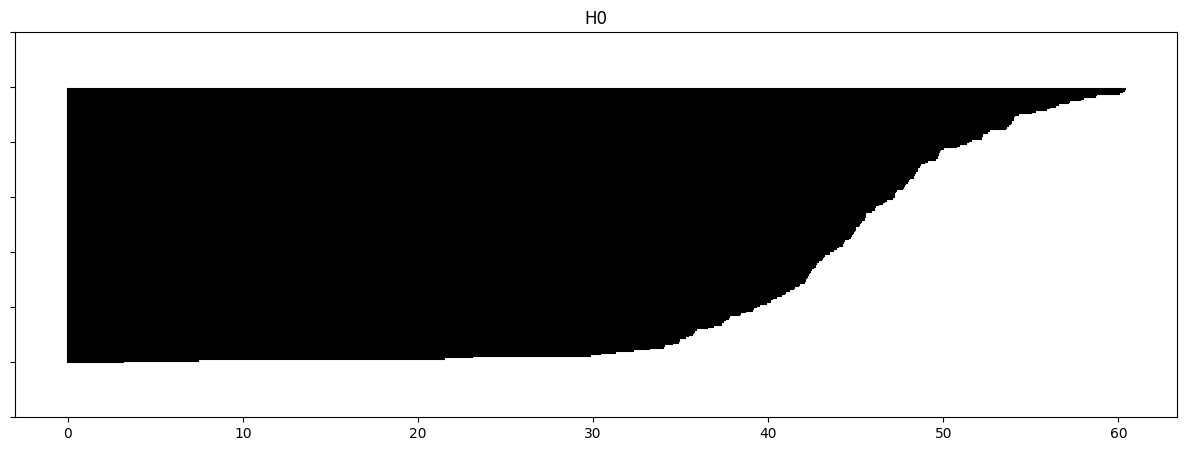

Test results


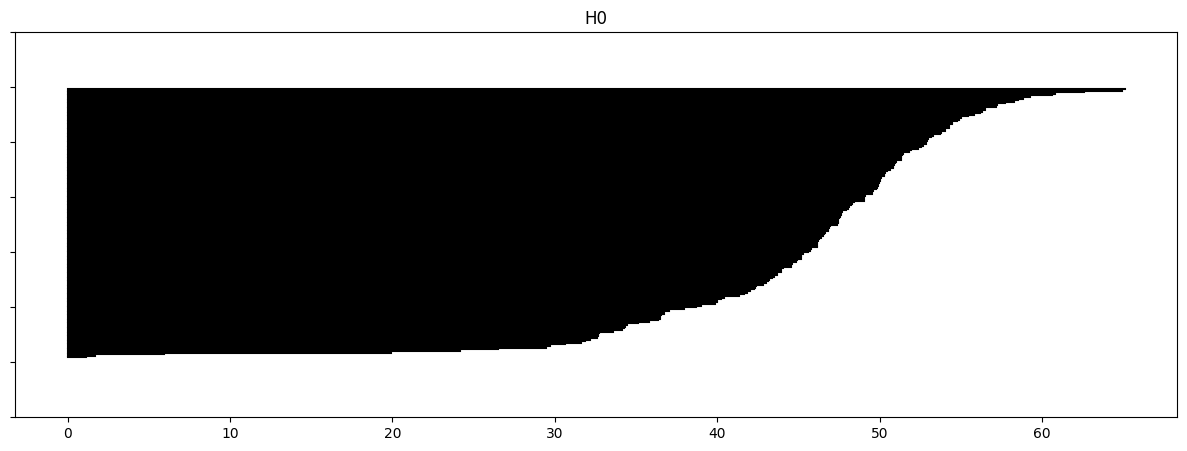

In [ ]:
barcodes_train = get_nn_barcodes(model = model_good, data = train_batch, layers = ['layer4', 'avgpool'], hom_type = 'standard', coefs_type = '2')
barcodes_test = get_nn_barcodes(model = model_good, data = test_batch, layers = ['layer4', 'avgpool'], hom_type = 'standard', coefs_type = '2')

print("Train results")
display(plot_barcode(barcodes_train['layer4']))
print("Test results")
display(plot_barcode(barcodes_test['layer4']))

Let's get barcodes for undertrained model too

Train results


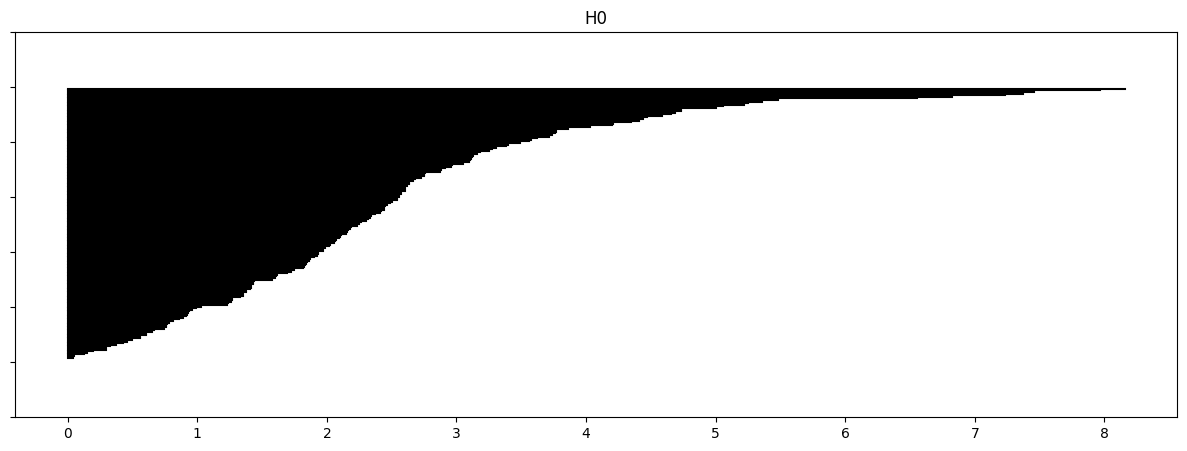

Test results


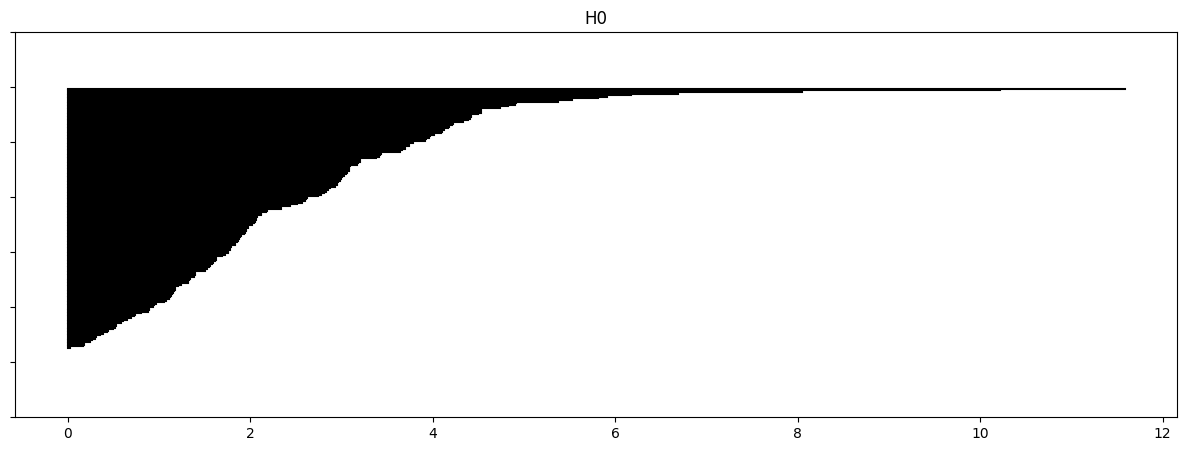

In [ ]:
barcodes_train1 = get_nn_barcodes(model = model_bad, data = train_batch, layers = ['layer4', 'avgpool'], hom_type = 'standard', coefs_type = '2')
barcodes_test1 = get_nn_barcodes(model = model_bad, data = test_batch, layers = ['layer4', 'avgpool'], hom_type = 'standard', coefs_type = '2')

print("Train results")
display(plot_barcode(barcodes_train1['layer4']))
print("Test results")
display(plot_barcode(barcodes_test1['layer4']))

In these examples, we can already see that the barcodes for the training and test data for a well-trained model are exactly the same, but for the test data they are significantly different.

Nevertheless, on practice it can be more suitable not to see the difference between pictures, but to compare some numbers and make conclusions based on this. For this purpose eXNN provide some metrics (on practice, often persistent entropy is the most useful, but there can be cases when others are more applicable).

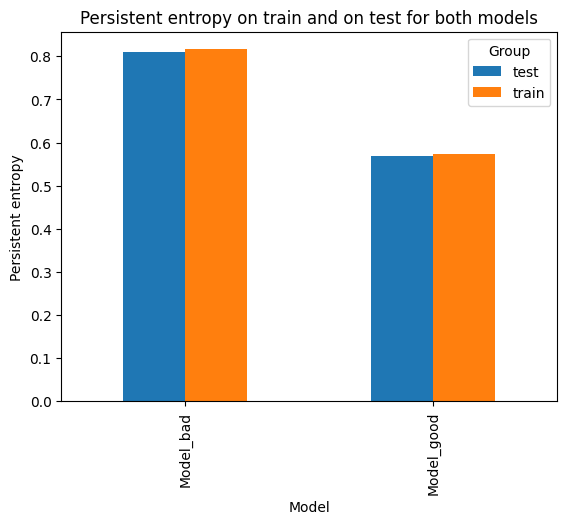

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame([['Model_good','train', compute_metric(barcodes_train['layer4'], 'normh')],
                   ['Model_good','test', compute_metric(barcodes_test['layer4'], 'normh')],
                   ['Model_bad','train', compute_metric(barcodes_train1['layer4'], 'normh')],
                   ['Model_bad','test', compute_metric(barcodes_test1['layer4'], 'normh')]],
                  columns=['Model','Group','Val'])

df.pivot("Model", "Group", "Val").plot(kind='bar')

plt.title("Persistent entropy on train and on test for both models")
plt.ylabel("Persistent entropy")
plt.show()

The graph shows that the numbers differ more for an undertrained model than for a well-trained one.

In [ ]:
df

,Model,Group,Val
0,Model_good,train,0.572326
1,Model_good,test,0.569141
2,Model_bad,train,0.816321
3,Model_bad,test,0.808888
